In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

import torch

import pennylane as qml
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
from pennylane import numpy as qnp


import time
import warnings
warnings.filterwarnings("ignore")

## Generating Bars and Stripes dataset

In [3]:
def get_bars_and_stripes(n):
    bitstrings = [list(np.binary_repr(i, n))[::-1] for i in range(2**n)]
    bitstrings = np.array(bitstrings, dtype=int)

    stripes = bitstrings.copy()
    stripes = np.repeat(stripes, n, 0)
    stripes = stripes.reshape(2**n, n * n)

    bars = bitstrings.copy()
    bars = bars.reshape(2**n * n, 1)
    bars = np.repeat(bars, n, 1)
    bars = bars.reshape(2**n, n * n)

    return np.vstack((stripes[0 : stripes.shape[0] - 1], bars[1 : bars.shape[0]]))

n = 2
size = n**2
data = get_bars_and_stripes(n)
# print(data.shape)



Sample bitstring: 1010


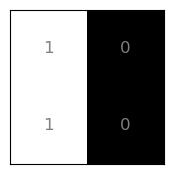

In [4]:
import matplotlib.pyplot as plt

sample = data[1].reshape(n, n)

plt.figure(figsize=(2, 2))
plt.imshow(sample, cmap="gray", vmin=0, vmax=1)
plt.grid(color="gray", linewidth=2)
plt.xticks([])
plt.yticks([])

for i in range(n):
    for j in range(n):
        text = plt.text(
            i,
            j,
            sample[j][i],
            ha="center",
            va="center",
            color="gray",
            fontsize=12,
        )

print(f"\nSample bitstring: {''.join(np.array(sample.flatten(), dtype='str'))}")

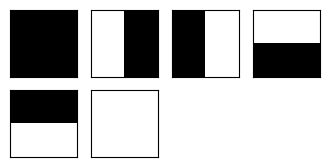

In [6]:
plt.figure(figsize=(4, 4))
j = 1
for i in data:
    plt.subplot(4, 4, j)
    j += 1
    plt.imshow(np.reshape(i, (n, n)), cmap="gray", vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])

## Getting Wavefunction of Dataset

In [15]:
n = 4
bitstrings_target = ['0000','0011','0101','1010','1100','1111']
nums_target = torch.tensor([int(b,2) for b in bitstrings_target],dtype=torch.long)
nums_target

tensor([ 0,  3,  5, 10, 12, 15])

In [19]:
wavefunctions = torch.zeros((len(nums_target),2**n), dtype=torch.float32)
wavefunctions[torch.arange(len(nums_target)),nums_target] = 1.0
wavefunctions

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [20]:
dm_batch = torch.einsum("bi,bj->bij",wavefunctions,wavefunctions)
target_dm = dm_batch.mean(dim=0)

In [22]:
torch.diag(target_dm)

tensor([0.1667, 0.0000, 0.0000, 0.1667, 0.0000, 0.1667, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1667, 0.0000, 0.1667, 0.0000, 0.0000, 0.1667])

## Functions

In [ ]:
from pennylane.math import reduce_statevector

n_qubits = n
n_ancillas = 3
total_qubits = n_qubits + n_ancillas

def sqrtm_torch(matrix:torch.Tensor) -> torch.Tensor:

    eigvals, eigvecs = torch.linalg.eig(matrix)
    eigvals = torch.sqrt(eigvals)
    return eigvecs @ torch.diag(eigvals) @ torch.linalg.inv(eigvecs)


def trdistance_loss(px:torch.Tensor, py:torch.Tensor) -> torch.Tensor:
    
    pxy = px - py
    pxy_2 = pxy @ pxy
    dagger_pxy2 = pxy_2.conj().T
    tr_distance = 0.5 * torch.trace(sqrtm_torch(dagger_pxy2 @ pxy_2))
    return tr_distance.real



def qcbm(circuit_fn, params:torch.Tensor, py:torch.Tensor, num_qubits=n_qubits):

    full_psi = circuit_fn(params)
    px = reduce_statevector(full_psi, indices=range(num_qubits))
    loss = trdistance_loss(px, py)
    return loss


In [44]:
def qcbm_circuit(params,total_qubits):

    rz_params = params[:total_qubits]
    ising_params1 = params[total_qubits:2*total_qubits]
    ising_params2 = params[2*total_qubits:]

    for i in range(total_qubits):
        qml.RX(rz_params[i],wires=i)

    for i in range(total_qubits-1):
        qml.IsingXY(ising_params1[i],wires=[i,i+1])
    qml.IsingXY(ising_params1[-1],wires=[total_qubits-1,0])


    for i in range(total_qubits-1):
        qml.IsingZZ(ising_params2[i],wires=[i,i+1])
    qml.IsingZZ(ising_params2[-1],wires=[total_qubits-1,0])


dev = qml.device("default.qubit",wires=total_qubits)
folds = 3

@qml.qnode(dev,interface="torch")
def circuit(input_params,folds=folds,num_qubits=n_qubits,ancilla_qubits=n_ancillas,total_qubits=total_qubits):

    for i in range(total_qubits):

        ## 1010.... initial state
        if i%2 == 0:
            qml.X(i)

    for i in range(folds):
        qcbm_circuit(params=input_params[i],total_qubits=total_qubits)
    
    output1 = qml.state()

    return output1


In [45]:
class FidelityLoss:
    """
    Loss class to compute the trace distance between two probability distributions.
    
    The loss is defined as:
    
        loss(px, py) = 0.5 * trace(sqrt((px - py)† * (px - py)))
    
    Note: The square root here is applied element-wise.
    """

    def __init__(self):
        # You can initialize parameters here if needed.
        pass

    # def fidelity(self, px, py):
    #     """
    #     Compute the trace distance of the difference matrix pxy.
        
    #     Parameters:
    #         pxy (numpy.ndarray): Difference of two probability distributions.
        
    #     Returns:
    #         float: 0.5 * trace of the element-wise square root of (pxy† * pxy).
    #     """
    #     # return px.conj().transpose() @ py
    #     return qml.math.fidelity(px,py)
    #     # return qnp.linalg.norm(pxy)  # temporary fix

    def __call__(self, px, py):
        """
        Compute the loss given two probability distributions px and py.
        
        Parameters:
            px, py (numpy.ndarray): Input probability distributions.
        
        Returns:
            float: Computed loss.
        """
        px_dm = qml.math.dm_from_state_vector(px)
        py = py
        return qml.math.fidelity(px_dm,py)
        # return self.tr_distance(pxy)
    
class VQC:

    def __init__(self,circ,fidelity,py):
        self.circ = circ
        self.fidelity = fidelity
        self.py = py

    def vqc_loss(self,params):
        full_psi = self.circ(params)
        # px = reduce_statevector(full_psi,indices=range(n_qubits))
        loss = self.fidelity(full_psi,self.py)
        # print("Statevector is",full_psi)
        return qnp.real(loss)

## Training the Model

In [71]:
initial_params = torch.rand((folds, 3 * total_qubits), requires_grad=True, dtype=torch.float32)

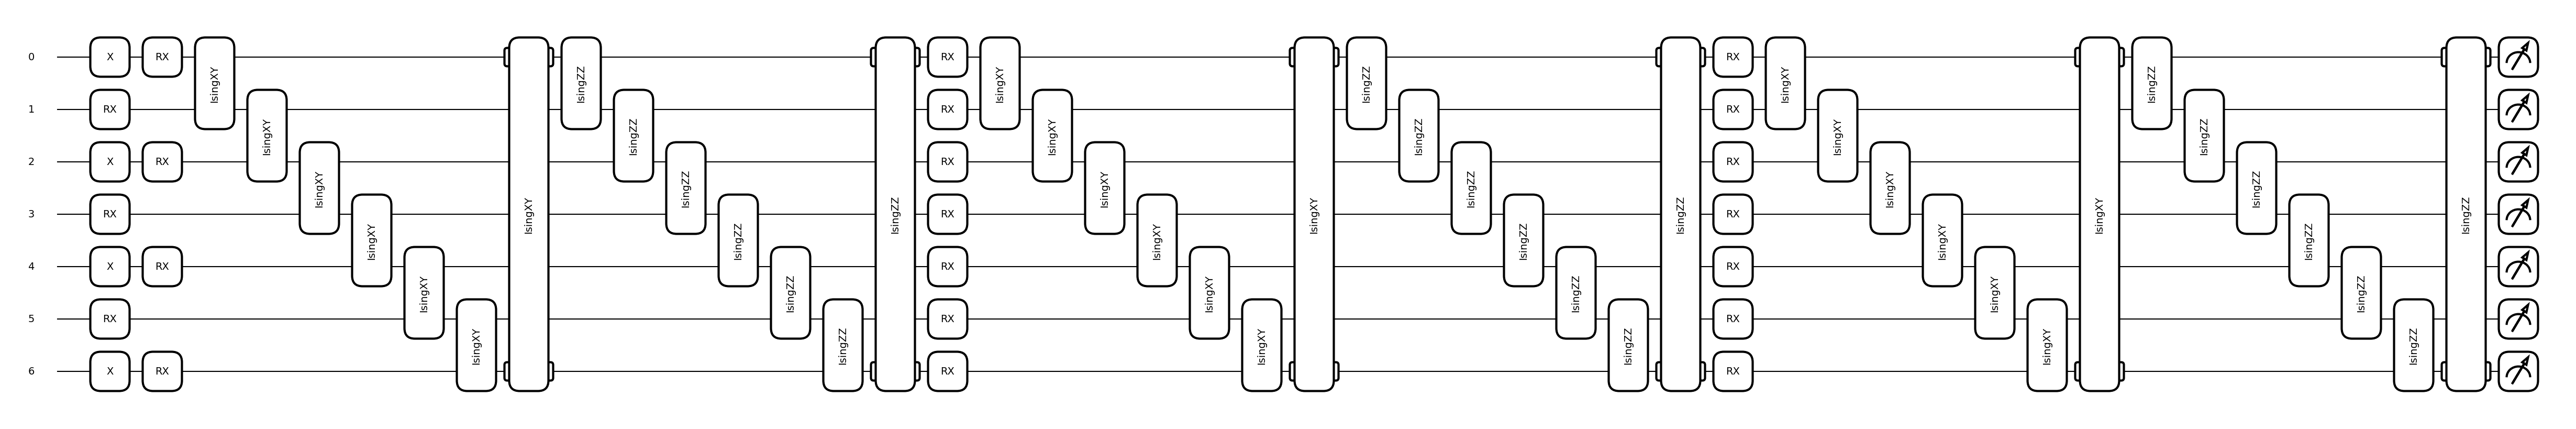

In [72]:
qml.draw_mpl(circuit,device='default')(initial_params)
plt.show()

In [ ]:
weights = initial_params
lr = 0.01
opt = torch.optim.Adam([weights], lr=lr)


loss_history = []
min_loss = qcbm(circuit, weights, target_dm)
optimal_params = torch.zeros((folds, 3* total_qubits), dtype=torch.float32)
n_epochs = 1500
i = 0

while i < n_epochs:

    i += 1
    start_time = time.time()
    opt.zero_grad()
    loss = qcbm(circuit, weights, target_dm)
    loss.backward()
    opt.step()
    end_time = time.time()

    if i%10 == 0:
        print(f"Step: {i} Loss: {loss} Time taken per iter: {end_time-start_time}")
    loss_history.append(loss.item())

    if loss < min_loss:
        min_loss = loss
        optimal_params = weights.detach().clone()


Step: 10 Loss: 0.00012089534681906759 Time taken per iter: 0.009936094284057617
Step: 20 Loss: 9.820617684267495e-05 Time taken per iter: 0.010638952255249023
Step: 30 Loss: 8.535158638674992e-05 Time taken per iter: 0.009660005569458008
Step: 40 Loss: 7.748845639792621e-05 Time taken per iter: 0.009239912033081055
Step: 50 Loss: 7.131305273391344e-05 Time taken per iter: 0.011091232299804688
Step: 60 Loss: 6.569598898197769e-05 Time taken per iter: 0.010601997375488281
Step: 70 Loss: 6.029446187492229e-05 Time taken per iter: 0.010770797729492188
Step: 80 Loss: 5.516840382655047e-05 Time taken per iter: 0.010966062545776367
Step: 90 Loss: 5.0184994903775534e-05 Time taken per iter: 0.009356021881103516
Step: 100 Loss: 4.539049377520496e-05 Time taken per iter: 0.009502410888671875
Step: 110 Loss: 4.081141273768952e-05 Time taken per iter: 0.009618043899536133
Step: 120 Loss: 3.648554372143394e-05 Time taken per iter: 0.009689092636108398
Step: 130 Loss: 3.2449122834891144e-05 Time tak

Text(0.5, 1.0, 'Loss Over Epochs')

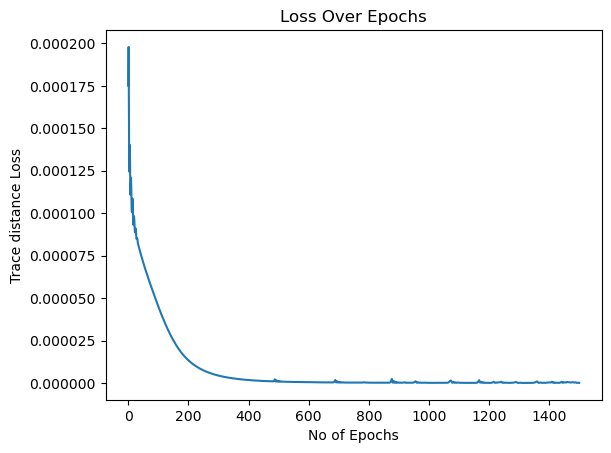

In [86]:
plt.plot(loss_history)
plt.xlabel("No of Epochs")
plt.ylabel("Trace distance Loss")
plt.title("Loss Over Epochs")

In [88]:
min_loss = loss_history[np.argmin(loss_history)]

print(f"The model converges to the Trace Distance Loss of {min_loss}")

The model converges to the Trace Distance Loss of 5.082163610217264e-08


In [89]:
psi = circuit(optimal_params)
reduced_dm = reduce_statevector(psi,indices=range(n_qubits))

In [90]:
np.round(np.diag(reduced_dm),4)

array([1.666e-01+0.j, 0.000e+00-0.j, 0.000e+00+0.j, 1.666e-01+0.j,
       0.000e+00+0.j, 1.666e-01+0.j, 1.000e-04+0.j, 0.000e+00-0.j,
       0.000e+00+0.j, 3.000e-04+0.j, 1.666e-01+0.j, 0.000e+00-0.j,
       1.666e-01+0.j, 0.000e+00-0.j, 0.000e+00+0.j, 1.666e-01+0.j])

## Training over the Register Basis

In [21]:
def vqc_circuit(params,total_qubits):

    rz_params = params[:total_qubits]
    ising_params1 = params[total_qubits:2*total_qubits]
    ising_params2 = params[2*total_qubits:]

    for i in range(total_qubits):
        qml.RX(rz_params[i],wires=n_qubits+i)
        qml.RY(ising_params1[i],wires=n_qubits+i)
        qml.RZ(ising_params2[i],wires=n_qubits+i)

    for i in range(total_qubits-1):
        # qml.IsingXY(ising_params1[i],wires=[n_qubits+i,n_qubits+i+1])
        qml.CNOT(wires=[n_qubits+i,n_qubits+i+1])
    qml.CNOT(wires=[n_qubits+total_qubits-1,n_qubits])
    # qml.IsingXY(ising_params1[-1],wires=[n_qubits+total_qubits-1,n_qubits])


    for i in range(total_qubits-1):
        qml.IsingZZ(ising_params2[i],wires=[n_qubits+i,n_qubits+i+1])
    qml.IsingZZ(ising_params2[-1],wires=[n_qubits+total_qubits-1,n_qubits])


dev = qml.device("default.qubit",wires=total_qubits)
folds = 3

@qml.qnode(dev,diff_method="backprop",interface="autograd")
def reg_circuit(input_params,trained_params=optimal_params,folds=folds,num_qubits=n_ancillas,total_qubits=total_qubits):
    
    for i in range(total_qubits):
        ## 1010.... initial state
        if i%2 == 0:
            qml.X(i)

    for i in range(folds):
        qcbm_circuit(params=trained_params[i],total_qubits=total_qubits)


    params = qnp.array(input_params, requires_grad=True)

    for i in range(folds):
        vqc_circuit(params=params[i],total_qubits=n_ancillas)
    
    output = qml.state()

    return output


In [22]:
reg_params = qnp.random.uniform(low=0.0, high=1.0, size=(folds, 3 * n_ancillas), requires_grad=True)

(<Figure size 7600x800 with 1 Axes>, <Axes: >)

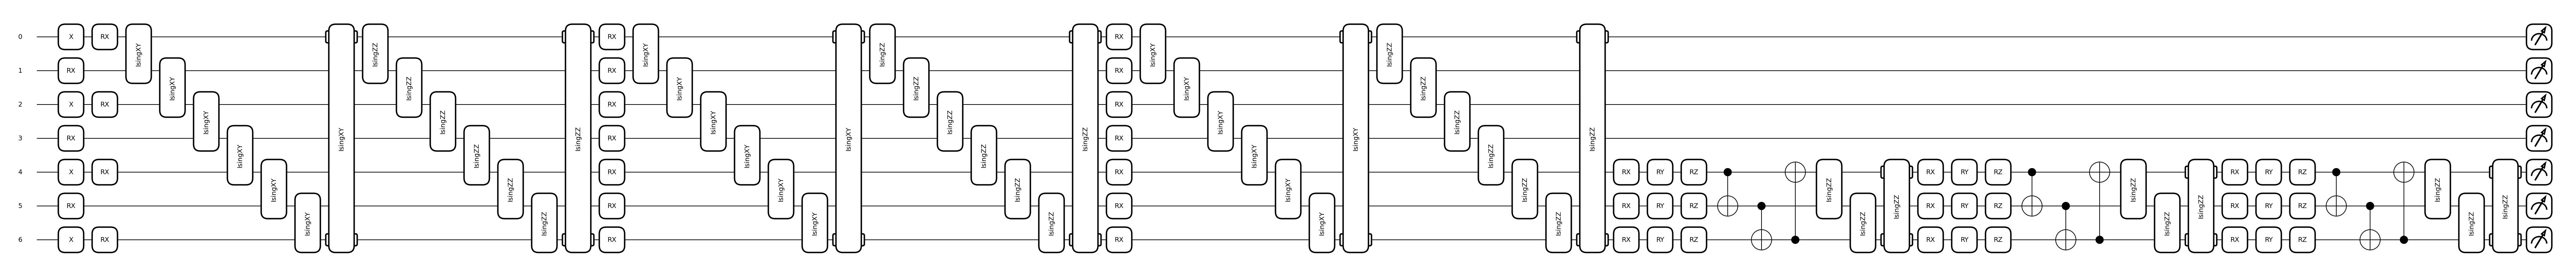

In [23]:
qml.draw_mpl(reg_circuit)(reg_params)

In [24]:
f1 = np.zeros(2**7)
f2 = np.zeros(2**7)
f3 = np.zeros(2**7)
f4 = np.zeros(2**7)
f5 = np.zeros(2**7)
f6 = np.zeros(2**7)

bitstrings_full_target = ['0000000','0011001','0101010','1010011','1100100','1111101']
nums_full_target = []
for i in bitstrings_full_target:
    nums_full_target += [int(i, 2)]
print(nums_full_target)

[0, 25, 42, 83, 100, 125]


In [25]:
# target_amps = 1/math.sqrt(len(nums_target))
f1[nums_full_target[0]] = 1.0
f2[nums_full_target[1]] = 1.0
f3[nums_full_target[2]] = 1.0
f4[nums_full_target[3]] = 1.0
f5[nums_full_target[4]] = 1.0
f6[nums_full_target[5]] = 1.0

target_full_dm = 1/len(nums_full_target) * (np.outer(f1,f1.conj()) + np.outer(f2,f2.conj()) + np.outer(f3,f3.conj()) + np.outer(f4,f4.conj()) 
                                             + np.outer(f5,f5.conj()) + np.outer(f6,f6.conj()))

In [26]:
np.diag(target_full_dm)

array([0.16666667, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.16666667, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.16666667, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [27]:
fid = FidelityLoss()
vqc = VQC(reg_circuit,fid,target_full_dm)

weights = reg_params
opt = AdamOptimizer(stepsize=0.1)

reg_loss = []
reg_parameters = []
n_epochs = 500
i = 0

while i < n_epochs:

    i += 1
    start_time = time.time()
    loss_val = vqc.vqc_loss(weights)
    weights = opt.step(vqc.vqc_loss,weights)
    # grad = grad(qcbm.qcbm_loss)()
    end_time = time.time()

    if i%10 == 0:
        print(f"Step: {i} Loss: {loss_val} Time taken per iter: {end_time-start_time}")

    reg_loss.append(loss_val)
    reg_parameters.append(weights)


Step: 10 Loss: 0.002061094210537155 Time taken per iter: 0.05213809013366699
Step: 20 Loss: 0.00023167364173759436 Time taken per iter: 0.05254507064819336
Step: 30 Loss: 0.00011773492101311428 Time taken per iter: 0.08652210235595703
Step: 40 Loss: 5.336285249206703e-05 Time taken per iter: 0.053878068923950195
Step: 50 Loss: 1.6794069109002567e-05 Time taken per iter: 0.052343130111694336
Step: 60 Loss: 8.294097994225253e-06 Time taken per iter: 0.056282758712768555
Step: 70 Loss: 2.4934868217637373e-06 Time taken per iter: 0.05332779884338379
Step: 80 Loss: 1.2000816393079638e-06 Time taken per iter: 0.05485224723815918
Step: 90 Loss: 3.925563262002377e-07 Time taken per iter: 0.05095815658569336
Step: 100 Loss: 1.1059573858617329e-07 Time taken per iter: 0.052497148513793945
Step: 110 Loss: 3.3680739058236594e-08 Time taken per iter: 0.08854174613952637
Step: 120 Loss: 8.51396141117284e-09 Time taken per iter: 0.053137779235839844
Step: 130 Loss: 5.116139381066268e-09 Time taken pe

In [28]:
optimal_reg_params = reg_parameters[np.argmin(reg_loss)]
full_psi = reg_circuit(optimal_reg_params)

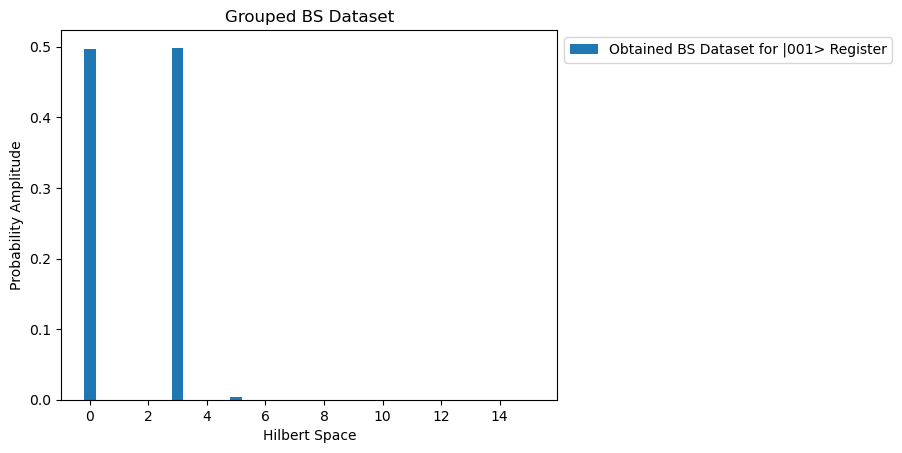

In [44]:
image = qnp.round(psi[7::8],3)
image /= qnp.linalg.norm(image)

w, x = 0.4, np.arange(len(image))

# plt.bar(x - w/2, target_psi, w, label='Original BS Dataset')
plt.bar(x, np.abs(image)**2, w, label='Obtained BS Dataset for |001> Register')

plt.xlabel('Hilbert Space')
plt.ylabel('Probability Amplitude')
plt.title('Grouped BS Dataset')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

In [33]:
nums_full_target

[0, 25, 42, 83, 100, 125]